In [1]:
import copy
import sys
import os


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R, lapse_dry
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots, fig_resize, update_fontsize, update_linewidth
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory
from isca_tools.thesis.lapse_theory import interp_var_at_pressure, get_bulk_lapse_rate, reconstruct_temp
from isca_tools import cesm
from isca_tools.convection.base import lcl_metpy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from geocat.comp.interpolation import interp_hybrid_to_pressure
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [221]:
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# lat_max = 90

In [241]:
is_isca_data = False
if not is_isca_data:
    # Load in CESM data
    quant_surf = 'land'
    path_cesm = '/Users/joshduffield/Documents/StAndrews/Isca/jobs/cesm/theory_adiabat/temp_dist/6month_summer_lev'
    exp_names = [f"pre_industrial", f"co2_2x"]
    n_exp = len(exp_names)

    var_keep = ['T', 'T_zonal_av', 'T_anom', 'PS', 'PREFHT', 'QREFHT', 'TREFHT', 'Z3', 'T_at_lcl', 'p_at_lcl',
                'lapse_below_lcl', 'lapse_above_lcl']
    for var in var_keep:
        if 'std' in var:
            continue
        var_keep.append(f"{var}_std")


    ds_quant3 = []
    for i in tqdm(range(len(exp_names))):
        ds_use = xr.open_dataset(f"{path_cesm}/{exp_names[i]}/{quant_surf}/output.nd2").isel(surface=0, plev=0)[var_keep]
        lat_use_ind = np.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min))[0]
        ds_quant3.append(ds_use.isel(lat=lat_use_ind))

    # Load in data
    ds_quant3 = xr.concat(ds_quant3, dim='exp')
    ds_quant3 = ds_quant3.assign_coords(exp=('exp', exp_names))
    ds_quant3 = ds_quant3.load()
    ds_quant3 = ds_quant3.transpose('exp', 'lat', 'quant')      # make order as expected for plotting
    pressure_ft = float(ds_quant3.plev)

    n_lat = ds_quant3.lat.size
    lat_weights = np.cos(np.deg2rad(ds_quant3.lat))

  0%|          | 0/2 [00:00<?, ?it/s]

In [242]:
# Load dataset - one at surface and one in free troposphere
if is_isca_data:
    var_keep = ['PS', 'QREFHT', 'TREFHT', 'height', 'temp']
    var_isca_dict = {'PS': 'ps', 'QREFHT': 'sphum_2m', 'TREFHT': 'temp_2m',
                     'height': 'height', 'temp': 'temp'}        # don't rename height or temp as only need one value from this

    use_time_start = 3      # ignore the first two years

    # Load dataset
    tau_lw_ref = 1
    tau_lw_warm = 1.5
    exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
    # exp_dir = 'tau_sweep/aquaplanet/depth=1/'

    # exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
    # exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
    #            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
    # color_seq_exp = ['b', 'g', 'orange', 'r']

    exp_names = [f"k={str(tau_lw_ref).replace('.','_')}_2m", f"k={str(tau_lw_warm).replace('.','_')}_2m"]
    # exp_names = exp_names[:1]
    n_exp = len(exp_names)
    ds = []
    albedo = []
    tau_sw = []
    tau_lw = []
    with tqdm(total=n_exp, position=0, leave=True) as pbar:
        for j in range(n_exp):
            ds_use = isca_tools.load_dataset(exp_dir + exp_names[j], decode_times=True)
            ds_use = ds_use.sel(time=ds_use.time.dt.year >= use_time_start)
            if is_isca_data:
                # Rename isca data to same as for CESM
                ds_use = ds_use[[var_isca_dict[key] for key in var_keep]]
                ds_use = ds_use.rename_vars({v: k for k, v in var_isca_dict.items()})
            else:
                ds_use = ds_use[var_keep]
            ds += [ds_use]      # only keep the surface and free troposphere values
            namelist = isca_tools.load_namelist(exp_dir + exp_names[j])  # Need this for albedo_value
            albedo += [namelist['mixed_layer_nml']['albedo_value']]
            tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
            tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
            if j==0:
                p0 = float(namelist['spectral_dynamics_nml']['reference_sea_level_press'])
                sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
                hybm = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
                hyam = np.zeros_like(hybm)
            pbar.update(1)

    pfull = ds_use.pfull
    n_pressure = ds[0].pfull.size

In [243]:
# Show where the land is
if is_isca_data:
    save_land_fig = False

    job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
    # changed name of this dataset to '_2m' so need to account for this here
    land_file_name = os.path.join(job_dir, exp_dir, exp_names[0].replace('_2m', ''), 'land.nc')
    is_land_data = os.path.exists(land_file_name)
    if is_land_data:
        fig, ax = plt.subplots(1,1)
        fig_resize(fig, 3)
        isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
        lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

        if save_land_fig:
            fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf")

In [244]:
# Load in across all latitudes, for given season
# Select region to combine latitudes over for all but one of the plots below
# Chose whether to only consider summer days or consider all days
if is_isca_data:
    # season = 'all'
    season = 'summer'
    # season = 'winter'
    if season == 'summer':
        if region == 'tropics':
            season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
    elif season == 'winter':
        if region == 'tropics':
            season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
        else:
            season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

    lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
    n_lat = len(lat_use_ind)
    lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]


    ds_all = []
    with tqdm(total=n_exp, position=0, leave=True) as pbar:
        for j in range(n_exp):
            ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

            # if is_land_data:
            #     # if not aquaplanet, then is land and only consider land longitudes
            #     ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

            if season == 'summer':
                ds_nh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['nh'])).sel(lat=slice(0, 90))
                ds_sh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['sh'])).sel(lat=slice(-90, 0))
                # Combine hemispheres and average over longitude, time and latitude.
                ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
            # ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            ds_all += [ds_use]
            pbar.update(1)
    ds_all = xr.concat(ds_all, dim=xr.DataArray(tau_lw, dims="exp", name="exp"))
    if is_isca_data:
        ds_all = ds_all.rename({'pfull': 'lev'})            # rename pfull as lev so same as cesm
    ds_all = ds_all.load()

In [245]:
# Interpolate onto pressure value desired for FT
if is_isca_data:
    pressure_ft = 400 * 100
    # Compute T500 and Z500 from pressure info
    ds_all['T'] = interp_hybrid_to_pressure(ds_all.temp, ds_all.PS, xr.DataArray(hyam, dims='lev'),
                                                  xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(pressure_ft), lev_dim='lev')
    ds_all['Z3'] = interp_hybrid_to_pressure(ds_all.height, ds_all.PS, xr.DataArray(hyam, dims='lev'),
                                                  xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(pressure_ft), lev_dim='lev')

In [246]:
if is_isca_data:
    ds_all['p_lcl'], ds_all['T_lcl'] = lcl_metpy(ds_all.TREFHT.fillna(0), ds_all.QREFHT.fillna(0), ds_all.PS.fillna(0))

In [247]:
# Get environmental info on pressure levels from average profile
def get_Tp_at_lcl(ds_prof, p_lcl, p_surf):
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surf, xr.DataArray(hyam, dims='lev'),
                                       xr.DataArray(hybm, dims='lev'), p0)
    return ds_interp.T, ds_interp.plev
if is_isca_data:
    ds_all['T_at_lcl'], ds_all['p_at_lcl'] = get_Tp_at_lcl(ds_all[['temp']], ds_all.p_lcl.fillna(0), ds_all.PS.fillna(0))

    ds_all['lapse_below_lcl'] = get_bulk_lapse_rate(ds_all.TREFHT, ds_all.T_at_lcl, ds_all.PS, ds_all.p_at_lcl) * 1000
    ds_all['lapse_above_lcl'] = get_bulk_lapse_rate(ds_all.T_at_lcl, ds_all.T_ft, ds_all.p_at_lcl, pressure_ft) * 1000

In [248]:
def lat_band_average(da, lat_av_width):
    results = []
    lat_vals = da.lat.values

    for lat_center in lat_vals:
        # Select latitudes in the band
        band = da.sel(lat=(abs(da.lat - lat_center) <= lat_av_width))
        results.append(area_weighting(band).mean(dim=['lat', 'lon']))

    out = xr.concat(results, dim="lat")
    out["lat"] = lat_vals
    return out

In [249]:
if is_isca_data:
    lat_av_window = 1       # av over +/-1 1 latitude band either side of that considering, if less than 2.4 then just zonal av
    if lat_av_window < 2.4:
        ds_all['T_zonal_av'] = ds_all['T'].mean(dim='lon')
    else:
        ds_all['T_zonal_av'] = lat_band_average(ds_all.T_ft, lat_av_window)
    ds_all['T_anom'] = ds_all['T'] - ds_all['T_zonal_av']
    ds_all = ds_all.load()

In [250]:
# ds_all['lapse_above_lcl'] = ds_all['lapse_above_lcl'].transpose(..., 'lon')

# for surf in ['land']:
#     # plt.scatter(ds_all['TREFHT'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1,
#     #             c=ds_all['lapse_above_lcl'].isel(plev=0).where(mask_surf[surf]), vmin=4, vmax=8, cmap='viridis')
#     plt.scatter(ds_all['TREFHT'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1,
#                 c=(ds_all['T_ft_spatial_anom']*0 + ds_all['T_ft_spatial_av']).where(mask_surf[surf]))
#     # plt.scatter(ds_all['p_lcl'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1)

In [251]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
if is_isca_data:
    mask_surf = {'land': np.isin(ds_all.lon, np.unique(lon_land)), 'ocean': ~np.isin(ds_all.lon, np.unique(lon_land))}
    quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
    quant_surf = 'ocean'                # Select surface to compute quantiles from
    n_quant = len(quant_plot)
    percentile_label = 'Temperature percentile, $x$'

    # quant2 is the actual quantile value rather than the average above a given quantile
    # ds_quant3 = {'T': np.zeros((n_exp, n_pressure, n_lat, n_quant)),
    #              'Z3': np.zeros((n_exp, n_pressure, n_lat, n_quant))}
    ds_quant3 = {}
    var_2d_list = ['PS', 'QREFHT', 'TREFHT', 'T', 'Z_ft', 'p_lcl', 'T_lcl','p_at_lcl', 'T_at_lcl',
                   'lapse_below_lcl', 'lapse_above_lcl', 'T_zonal_av', 'T_anom']
    for key in var_2d_list:
        ds_quant3[key] = np.zeros((n_exp, n_lat, n_quant))
        ds_quant3[key+'_std'] = np.zeros((n_exp, n_lat, n_quant))


    with tqdm(total=n_exp*n_quant*n_lat, position=0, leave=True) as pbar:
        for j in range(n_exp):
            ds_use = ds_all.isel(exp=j)
            ds_use = ds_use.isel(lon=mask_surf[quant_surf])
            ds_quant3['TREFHT'][j] = ds_use.TREFHT.quantile(quant_plot/100, dim=['lon', 'time'], keep_attrs=True).transpose()
            for k in range(n_lat):
                # only 1 plev, so select it here to remove it
                ds_use = ds_all.isel(exp=j, lat=k, plev=0).isel(lon=mask_surf[quant_surf])
                ds_use['T_ft_spatial_av'] = ds_use.T_ft_spatial_anom * 0 + ds_use['T_ft_spatial_av']        # make have same dimensions as other 2d stuff
                ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
                for q, quant in enumerate(quant_plot):
                    use_ind = get_quant_ind(ds_use.TREFHT, quant, 0.5, 0.5)
                    # ds_quant3['T'][j, :, k, q] = ds_use.T[:, use_ind].mean(dim='lon_time')
                    # ds_quant3['Z3'][j, :, k, q] = ds_use.Z3[:, use_ind].mean(dim='lon_time')
                    for key in var_2d_list:
                        ds_quant3[key][j, k, q] = ds_use[key][use_ind].mean(dim='lon_time')
                        ds_quant3[key+'_std'][j, k, q] = ds_use[key][use_ind].std(dim='lon_time')
                    pbar.update(1)

    # Convert to dataset
    coords = {"exp": tau_lw, "lev": np.asarray(pfull)*100, "lat": ds_all.lat, "quant": quant_plot}
    ds_quant3 = xr.Dataset({
        key: xr.DataArray(ds_quant3[key], dims=["exp", "lev", "lat", "quant"] if key in ['T', 'Z3'] else ["exp", "lat", "quant"],
                          coords=coords if key in ['T', 'Z3'] else {k: coords[k] for k in ["exp", "lat", "quant"]}) for key in ds_quant3
    })
    ds_quant3['PREFHT'] = ds_quant3['PS']

In [252]:
def plot_with_std(ax, x, var, var_std, color='C0', alpha=0.2, label=None, ax_lat=0, lat_weights=lat_weights):
    ignore_lat_ind = np.where(np.isnan(var).sum(dim='quant')>0)[0]
    if len(ignore_lat_ind) > 0:
        print(f'Latitudes={var.lat.isel(lat=ignore_lat_ind).values} contain nan and are ignored')
        keep_lat_ind = np.where(np.isnan(var).sum(dim='quant')==0)[0]
        var = var.isel(lat=keep_lat_ind)
        var_std = var_std.isel(lat=keep_lat_ind)
        lat_weights = lat_weights[keep_lat_ind]
    var_min = var-var_std
    var_max = var+var_std


    if lat_weights is not None:
        var = np.average(var, axis=ax_lat, weights=lat_weights)
        var_min = np.average(var_min, axis=ax_lat, weights=lat_weights)
        var_max = np.average(var_max, axis=ax_lat, weights=lat_weights)
    ax.plot(x, var, color=color, label=label)
    ax.fill_between(x, var_min, var_max, color=color, alpha=alpha)

ax_linewidth = plt.rcParams['axes.linewidth']
percentile_label = 'Temperature percentile, $x$'

Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored


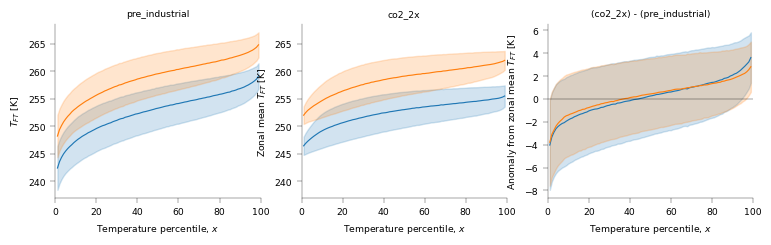

In [253]:
fig, ax = plt.subplots(1,3, sharex=True)
fig_resize(fig, 9)
for i in range(n_exp):
    plot_with_std(ax[0], ds_quant3.quant, ds_quant3.T.isel(exp=i), ds_quant3.T_std.isel(exp=i), color=f'C{i}')
    plot_with_std(ax[1], ds_quant3.quant, ds_quant3.T_zonal_av.isel(exp=i), ds_quant3.T_zonal_av_std.isel(exp=i), color=f'C{i}')
    plot_with_std(ax[2], ds_quant3.quant, ds_quant3.T_anom.isel(exp=i), ds_quant3.T_anom_std.isel(exp=i), color=f'C{i}')
ax[0].sharey(ax[1])
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$T_{FT}$ [K]')
ax[1].set_ylabel('Zonal mean $T_{FT}$ [K]')
ax[2].set_ylabel('Anomaly from zonal mean $T_{FT}$ [K]')
for i in range(len(ax)):
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f'{str(ds_quant3.exp[i].values)}' if i<n_exp else f'({str(ds_quant3.exp[1].values)}) - ({str(ds_quant3.exp[0].values)})')
update_fontsize(fig)
update_linewidth(fig)
ax[2].axhline(0, color='k', lw=ax_linewidth)
plt.show()

Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored


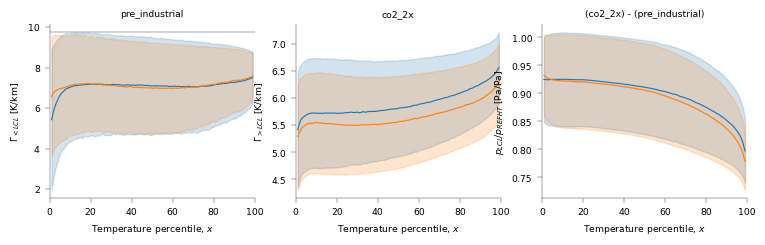

In [254]:
fig, ax = plt.subplots(1,3, sharex=True)
fig_resize(fig, 9)
for i in range(n_exp):
    plot_with_std(ax[0], ds_quant3.quant, ds_quant3.lapse_below_lcl.isel(exp=i), ds_quant3.lapse_below_lcl_std.isel(exp=i), color=f'C{i}')
    plot_with_std(ax[1], ds_quant3.quant, ds_quant3.lapse_above_lcl.isel(exp=i), ds_quant3.lapse_above_lcl_std.isel(exp=i), color=f'C{i}')
    var_use = ds_quant3.p_at_lcl.isel(exp=i)/ds_quant3.PREFHT.isel(exp=i)
    var_use_error = var_use * np.sqrt((ds_quant3.p_at_lcl_std.isel(exp=i)/ds_quant3.p_at_lcl.isel(exp=i))**2 +
                                      (ds_quant3.PREFHT_std.isel(exp=i)/ds_quant3.PREFHT.isel(exp=i))**2)
    plot_with_std(ax[2], ds_quant3.quant, var_use, var_use_error, color=f'C{i}')

ax[0].set_ylabel('$\Gamma_{<LCL}$ [K/km]')
ax[1].set_ylabel('$\Gamma_{>LCL}$ [K/km]')
ax[2].set_ylabel('$p_{LCL}/p_{REFHT}$ [Pa/Pa]')
ax[0].set_xlim(0, 100)
for i in range(len(ax)):
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f'{str(ds_quant3.exp[i].values)}' if i<n_exp else f'({str(ds_quant3.exp[1].values)}) - ({str(ds_quant3.exp[0].values)})')
update_fontsize(fig)
update_linewidth(fig)
ax[0].axhline(lapse_dry*1000, color='k', lw=ax_linewidth, label='Dry')
plt.show()

Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored


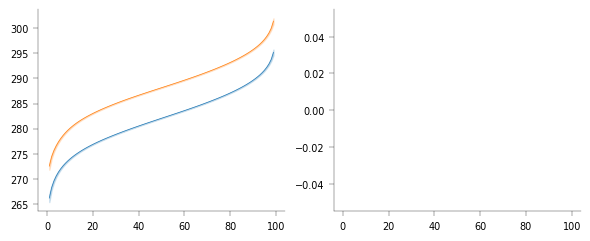

In [255]:
fig, ax = plt.subplots(1,2, sharex=True)
fig_resize(fig, 7)
for i in range(n_exp):
    plot_with_std(ax[0], ds_quant3.quant, ds_quant3.TREFHT.isel(exp=i), ds_quant3.TREFHT_std.isel(exp=i), color=f'C{i}')
ax[1].plot(ds_quant3.quant, np.average(ds_quant3.TREFHT.isel(exp=1)-ds_quant3.TREFHT.isel(exp=0), axis=0, weights=lat_weights), color='k')
plt.show()

In [256]:
ds_ref = copy.deepcopy(ds_quant3.sel(quant=50))
ds_ref['T_anom'] *= 0                # for reference have spatial anomaly equal zero
ds_ref['T'] = ds_ref['T_zonal_av']
# ds_ref['lapse_below_lcl'] = ds_ref['lapse_below_lcl']*0 + lapse_dry*1000            # for reference have lapse below lcl same as dry adiabat
# ds_ref['p_at_lcl'] = ds_all.p_lcl.isel(lon=mask_surf[quant_surf]).mean(dim=['lon', 'time'])     # set ref p_at_lcl from p_lcl to avoid zeros

# Reconstruct reference temperature from reference values of other quantities
ds_ref['TREFHT'] = reconstruct_temp(ds_ref['T'], ds_ref['PREFHT'], ds_ref['p_at_lcl'], pressure_ft, ds_ref.lapse_below_lcl/1000,
                                    ds_ref.lapse_above_lcl/1000)

In [257]:
TREFHT_anom_breakdown_anom = {key: ds_quant3[key] - ds_ref[key] for key in ds_ref}
TREFHT_anom_breakdown_anom['p_at_lcl'] = ds_quant3.p_at_lcl/ds_quant3.PREFHT - ds_ref.p_at_lcl/ds_ref.PREFHT
TREFHT_anom_breakdown_anom['PREFHT'] = float(ds_ref.plev)/ds_quant3.PREFHT - float(ds_ref.plev)/ds_ref.PREFHT
TREFHT_anom_breakdown_sensitivity = {'T_zonal_av': ds_ref.TREFHT/ds_ref.T,
                                       'T_anom': ds_ref.TREFHT/ds_ref.T,
                                       'lapse_below_lcl': -ds_ref.TREFHT * np.log(ds_ref.p_at_lcl/ds_ref.PREFHT) * R/g / 1000,
                                       'lapse_above_lcl': ds_ref.TREFHT * np.log(ds_ref.p_at_lcl/float(ds_ref.plev)) * R/g / 1000,
                                       'p_at_lcl': R/g * (ds_ref.lapse_above_lcl-ds_ref.lapse_below_lcl)/1000 *
                                                   ds_ref.PREFHT/ds_ref.p_at_lcl * ds_ref.TREFHT,
                                       'PREFHT': -R/g * ds_ref.lapse_above_lcl/1000 * (ds_ref.PREFHT/float(ds_ref.plev) * ds_ref.TREFHT)}
TREFHT_anom_breakdown_cont = {key: TREFHT_anom_breakdown_anom[key] * TREFHT_anom_breakdown_sensitivity[key]
                              for key in TREFHT_anom_breakdown_sensitivity}
TREFHT_anom_theory = sum(TREFHT_anom_breakdown_cont.values())

colors_cont_lapse = {'PREFHT': 'C3', 'lapse_below_lcl': 'C4',
                     'p_at_lcl': 'C0', 'T_zonal_av': 'C2', 'T_anom': 'C2', 'lapse_above_lcl': 'C1'}

In [258]:
quant_median_ind = np.where(ds_quant3.quant==50)[0][0]
def plot_sf(var, ax_lat=0, lat_weights=lat_weights, ax_quant=1, norm_by_median=True, median_ind=quant_median_ind):
    ignore_lat_ind = np.where(np.isnan(var).sum(dim='quant')>0)[0]
    if len(ignore_lat_ind) > 0:
        print(f'Latitudes={var.lat.isel(lat=ignore_lat_ind).values} contain nan and are ignored')
        keep_lat_ind = np.where(np.isnan(var).sum(dim='quant')==0)[0]
        var = var.isel(lat=keep_lat_ind)
        lat_weights = lat_weights[keep_lat_ind]
    if norm_by_median:
        return np.average(var - np.take(var, indices=[median_ind], axis=ax_quant) + 1, axis=ax_lat, weights=lat_weights)
    else:
        return np.average(var, axis=ax_lat, weights=lat_weights)

Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518
 -57.01570681 -56.07329843] contain nan and are ignored
Latitudes=[-61.72774869 -60.78534031 -59.84293194 -58.90052356 -57.95811518


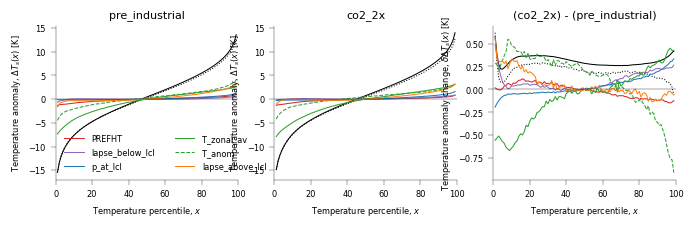

In [259]:
norm_median = False    # force all lines through x=50
save_sf_theory_fig = True
fig, ax = plt.subplots(1,3, sharex=True)
fig_resize(fig, 8)
for i in range(n_exp):
    ax[i].plot(ds_quant3.quant, plot_sf((ds_quant3.TREFHT - ds_ref.TREFHT).isel(exp=i), norm_by_median=norm_median), color='k')
    ax[i].plot(ds_quant3.quant, plot_sf(TREFHT_anom_theory.isel(exp=i), norm_by_median=norm_median), color='k', linestyle=':')
    for k, key2 in enumerate(colors_cont_lapse):
        ax[i].plot(ds_quant3.quant, plot_sf(TREFHT_anom_breakdown_cont[key2].isel(exp=i), norm_by_median=norm_median), color=colors_cont_lapse[key2],
                   label=key2, linestyle='--' if 'anom' in key2 else None)
ax[2].plot(ds_quant3.quant, plot_sf((ds_quant3.TREFHT - ds_ref.TREFHT).isel(exp=1) -
                               (ds_quant3.TREFHT - ds_ref.TREFHT).isel(exp=0), norm_by_median=norm_median), color='k')
ax[2].plot(ds_quant3.quant, plot_sf(TREFHT_anom_theory.isel(exp=1) - TREFHT_anom_theory.isel(exp=0), norm_by_median=norm_median),
           color='k', linestyle=':')
for k, key2 in enumerate(colors_cont_lapse):
    ax[2].plot(ds_quant3.quant, plot_sf(TREFHT_anom_breakdown_cont[key2].isel(exp=1)-TREFHT_anom_breakdown_cont[key2].isel(exp=0),
                                   norm_by_median=norm_median), color=colors_cont_lapse[key2],
               label=key2, linestyle='--' if 'anom' in key2 else None)
ax[0].set_xlim(0,100)
ax[0].set_ylabel('Temperature anomaly, $\Delta T_s(x)$ [K]')
ax[1].set_ylabel('Temperature anomaly, $\Delta T_s(x)$ [K]')
ax[2].set_ylabel('Temperature anomaly change, $\delta \Delta T_s(x)$ [K]')
ax[0].sharey(ax[1])
update_linewidth(fig)
ax[0].legend(ncol=2)
update_fontsize(fig)
for i in range(3):
    ax[i].axhline(0, linewidth=ax_linewidth, color='k')
    ax[i].set_xlabel(percentile_label)
    ax[i].set_title(f'{str(ds_quant3.exp[i].values)}' if i<n_exp else f'({str(ds_quant3.exp[1].values)}) - ({str(ds_quant3.exp[0].values)})')
# ax.tick_params(length=8, direction='out')

plt.show()
if save_sf_theory_fig:
    isca_tools.savefig(fig)